필요한 라이브러리 가져오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw


In [3]:
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"),"aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir = data_dir,
    split=['train','test'],
    shuffle_files=True,
    with_info=True,
)

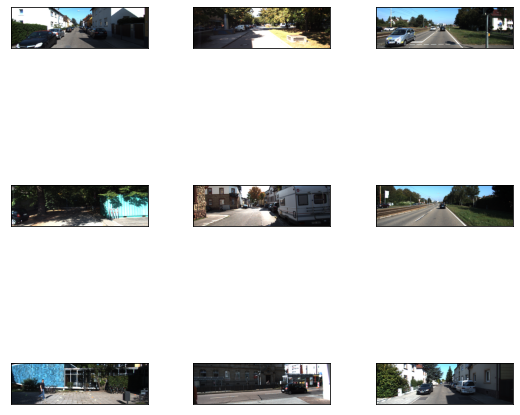

In [4]:
_ = tfds.show_examples(ds_train, ds_info)

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

## 데이터 직접 확인하기

--------Example---------
['image', 'image/file_name', 'objects']
--------objects--------
{'alpha': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.56, -1.54], dtype=float32)>, 'bbox': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.49986666, 0.47157004, 0.54528   , 0.48888084],
       [0.50794667, 0.45141706, 0.54906666, 0.466562  ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1.26, 1.6 , 3.56],
       [1.37, 1.63, 3.57]], dtype=float32)>, 'location': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-1.04,  1.11, 55.74],
       [-3.69,  1.06, 66.86]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>, 'rotation_y': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.58, -1.6 ], dtype=float32)>, 'truncated': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>, 'type': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>}


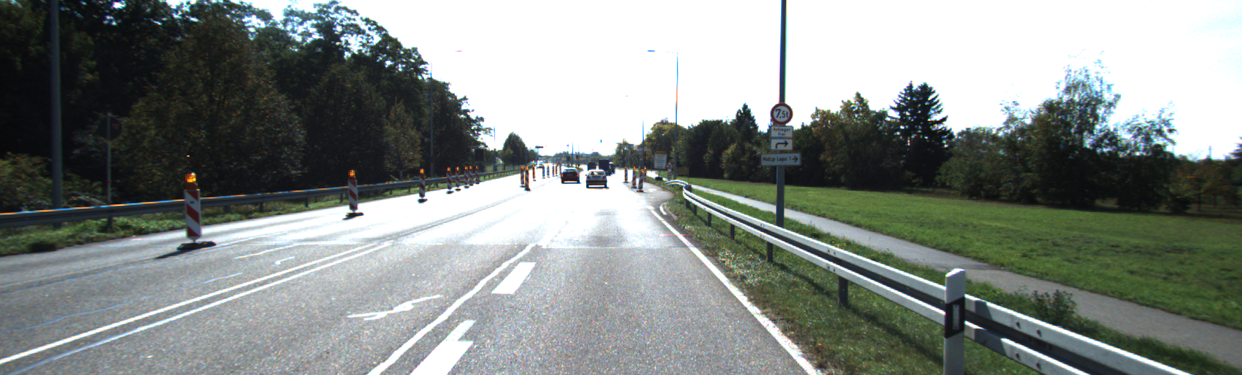

In [6]:
sample = ds_train.take(1)

for example in sample:
    print('--------Example---------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]
    
    
print('--------objects--------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242  height: 375
(2, 4)
[585.69 187.55 607.19 170.52]
[560.66    184.52    579.47003 169.1    ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F76143E5550>


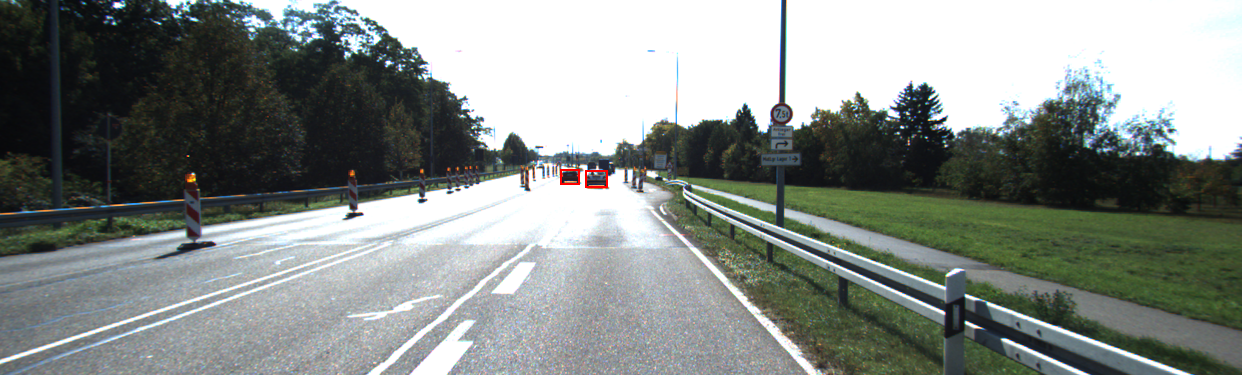

In [8]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())


## 데이터 포맷 변경

### 클래스 및 바운딩 박스 정보 추출

In [9]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            
    return df
        
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)


100%|██████████| 6347/6347 [22:20<00:00,  4.73it/s]


In [10]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:35<00:00,  4.57it/s]


### 클래스 맵핑

In [11]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')
            
save_class_format(class_txt_path)

Done


## 셋팅

In [15]:
# RetinaNet 훈련이 시작됩니다!! 10epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt
print("Done")

2021-10-19 10:28:17.787369: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-19 10:28:19.442509: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-19 10:28:19.443422: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-19 10:28:19.451968: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-19 10:28:19.452016: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-19 10:28:19.454826: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-19

학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환

In [16]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

2021-10-19 11:13:27.841239: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-19 11:13:29.446100: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-19 11:13:29.447051: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-19 11:13:29.454952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-19 11:13:29.454992: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-19 11:13:29.458794: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-19

In [17]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[593.258   174.94684 626.65314 205.7895 ]
[177.00996 133.21178 368.0911  237.0338 ]
[371.23987 184.26201 420.53012 211.0088 ]
[534.24286 159.69641 565.7249  189.95097]
[441.0293  175.13908 472.97635 199.63863]


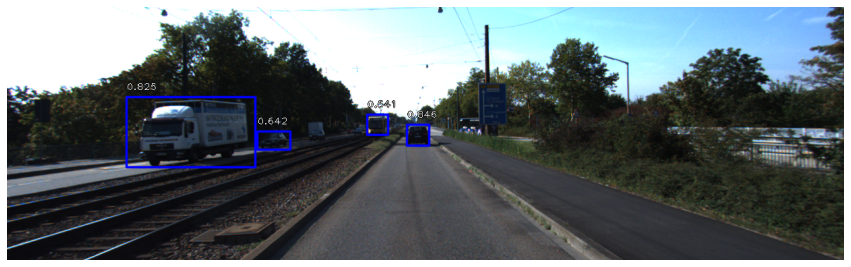

In [18]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path)

[770.10736 146.4337  835.515   308.4661 ]
[795.2193  156.10587 850.6009  287.53622]


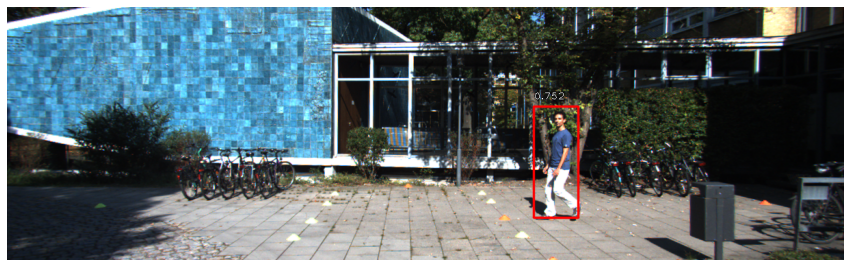

In [19]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)

# ⭐️ 프로젝트: 자율주행 보조 시스템 만들기

## 1. 자율주행 시스템 만들기

----------------------------------

위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

* 입력으로 이미지 경로를 받습니다.
* 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
* 조건은 다음과 같습니다.    

    * 사람이 한 명 이상 있는 경우
    * 차량의 크기(width or height)가 300px이상인 경우

[770.10736 146.4337  835.515   308.4661 ]
[795.2193  156.10587 850.6009  287.53622]


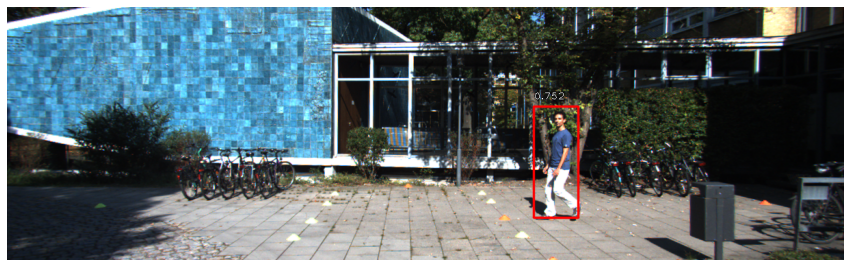

Stop


In [20]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit=300, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0)  # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if visualize:
        result = 'Go'
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.4:  # 일정 점수 이하는 제외
                break
            b = box.astype(int)
            w = b[2]-b[0]
            h = b[3]-b[1]
            
            if w >= size_limit or h >= size_limit or label == 1:
                result = 'Stop'
            else:
                result = 'Go'
            
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()
        
        return result
    
print(self_drive_assist(img_path))

## 2. 자율주행 시스템 평가하기

----------------------------------


아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다.      
10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

[770.10736 146.4337  835.515   308.4661 ]
[795.2193  156.10587 850.6009  287.53622]


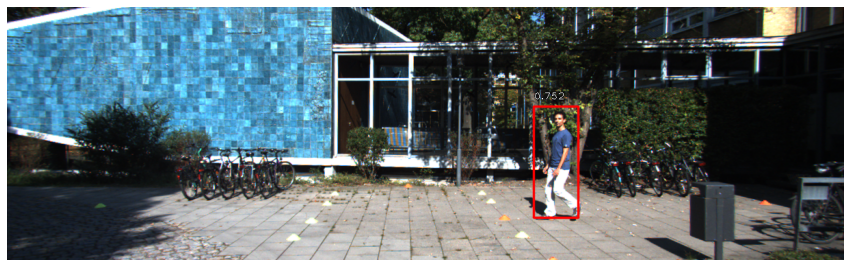

[418.53693 158.50108 493.73904 331.54608]
[1029.1967    94.62118 1219.9117   291.56894]


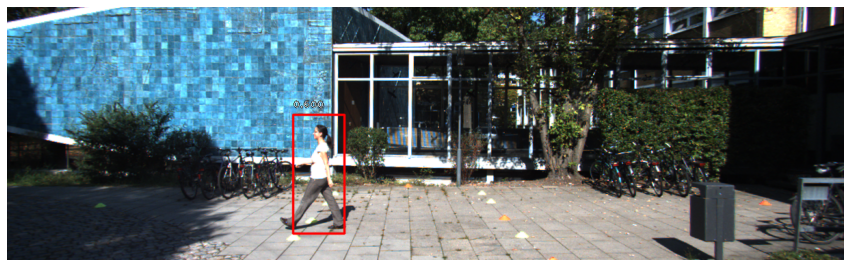

[  5.6062007 199.52574   302.30173   369.12827  ]
[742.19977 162.10861 886.55365 215.55798]
[ 991.4599   145.29251 1030.7001   217.06711]
[ 981.9235   142.40454 1017.05835  212.80353]


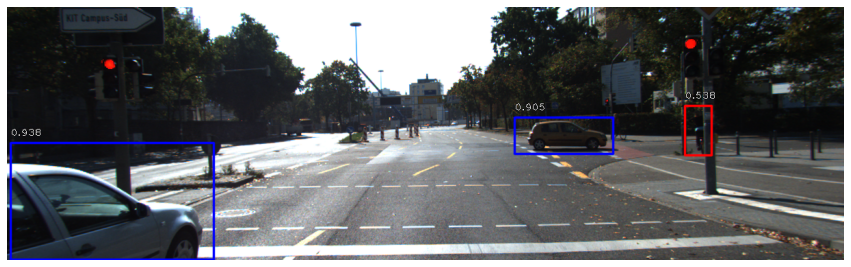

[ 738.10284    77.532906 1096.1058    339.25635 ]
[657.9312  144.48825 735.4823  224.36684]
[ 41.007565 143.291    368.59543  326.54135 ]
[430.87726 161.83673 560.42896 211.76273]
[670.3906  152.4037  759.3885  241.47394]
[348.45395 172.65503 496.447   225.92433]
[388.47452 167.17241 534.22675 218.18254]
[649.2186  159.84895 712.9428  216.46207]
[143.46385 161.93427 393.94916 285.08777]
[698.6576  159.44023 791.9725  262.7852 ]
[ 752.26605  154.4402  1022.53485  367.61047]


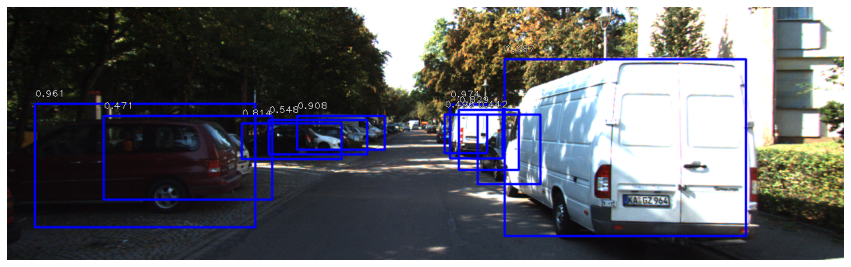

[ 911.3536   164.86067 1241.0684   373.6249 ]
[734.501   165.6828  859.58563 255.47849]
[564.6734  180.73637 621.4701  216.6271 ]
[699.64087 146.25317 780.05457 215.69376]
[707.5444  152.30092 818.33014 234.02603]
[691.81836 156.2068  754.74274 209.09811]
[583.4136  178.20316 630.95703 208.23198]
[ 861.29694  186.89253 1105.5173   371.11597]


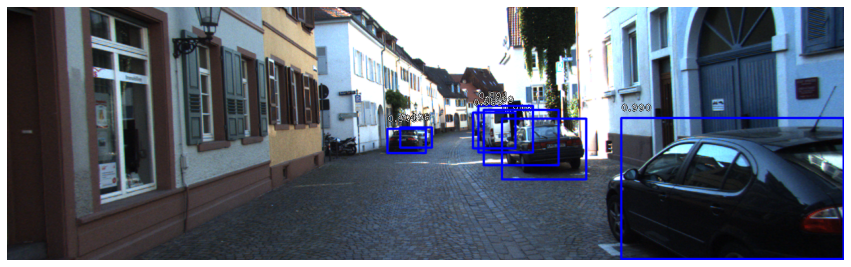

[593.258   174.94684 626.65314 205.7895 ]
[177.00996 133.21178 368.0911  237.0338 ]
[371.23987 184.26201 420.53012 211.0088 ]
[534.24286 159.69641 565.7249  189.95097]
[441.0293  175.13908 472.97635 199.63863]


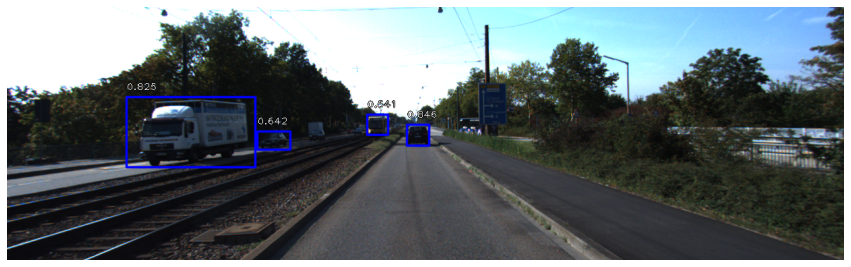

[515.3539  179.25394 571.7274  215.61559]
[629.9644  174.69583 669.93616 211.7958 ]
[530.00226 176.14627 582.20074 208.23181]
[626.49194 172.01657 658.5247  202.60887]


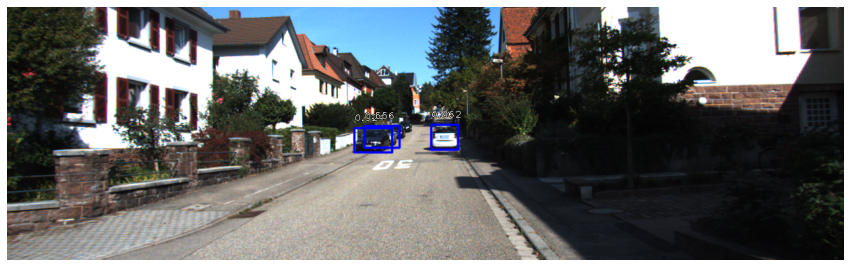

[819.905   152.9964  880.45605 179.73897]
[539.6422  166.54343 568.7889  190.76253]
[  0.       173.03728   55.843052 229.26782 ]


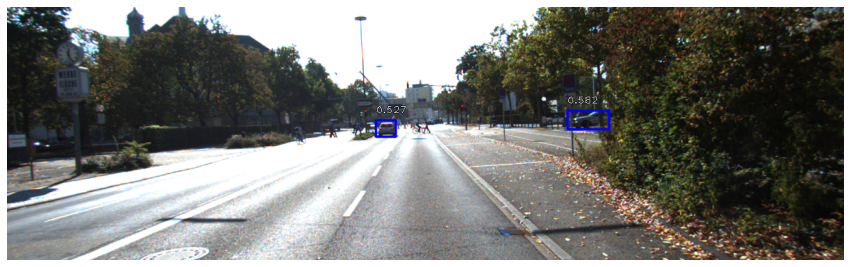

[690.81586 168.74275 794.9731  256.01337]
[686.3743  184.67223 747.2444  239.5086 ]


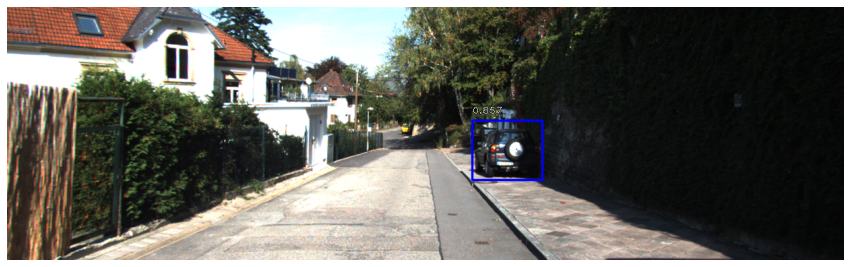

[  0.      191.19417 238.881   318.33786]
[152.20856 184.5336  348.72244 258.5654 ]
[437.3799  179.07968 492.4021  210.44897]
[ 51.569424 187.1577   318.50485  279.03726 ]
[215.73997 177.71033 377.00662 243.001  ]
[270.79584 175.58585 414.42856 229.85129]
[ 890.6096   142.7783  1060.6581   196.75049]
[808.6307  159.04149 896.4556  195.06337]
[647.6787  170.68367 674.2991  193.02739]
[1074.3534   145.09146 1233.4906   199.51617]


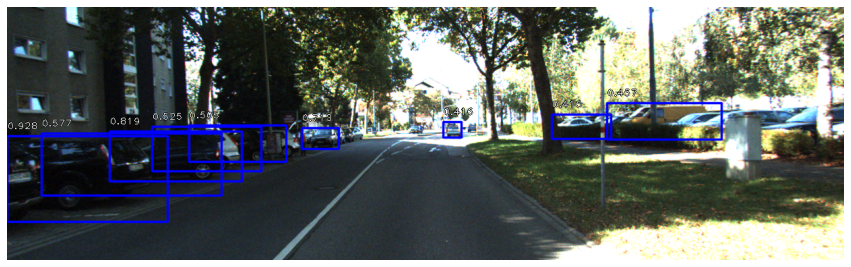

80점입니다.


In [21]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)